# Reformatting 
### Fixing error that caused long text to be split into columns

In [1]:
import csv
def fix_rows():
    input_file = "movie_reviews.csv"
    output_file = "fixed_movie_reviews.csv"
    with open(input_file, 'r', newline='') as infile, open(output_file, 'w', newline='') as outfile:
        reader = csv.reader(infile, delimiter="\t")
        writer = csv.writer(outfile)
        writer.writerow(["id","movie_title","release_year","synopsis","review","first_100"])

        for row in reader:
            for row in reader:
                if len(row) > 6: #Deals with rows with more than 6 columns
                    merged_columns = ' '.join(row[4:-1])
                    new_row = row[:4] + [merged_columns] + [row[-1]]
                    writer.writerow(new_row)
                elif len(row) == 6: 
                    writer.writerow(row)
                else: #If row has less than 6 columns, we skip
                    pass
fix_rows()

# Normalizing Text

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import emoji
def normalize():
    df = pd.read_csv("fixed_movie_reviews.csv")
    df['review'] = df['review'].str.lower() #Turn into lowercase
    df['review'] = df['review'].apply(str) #Turn into str type
    df['review'] = df['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x)) #Gets rid of non-alphabet
    df['review'] = df['review'].apply(lambda x: word_tokenize(x)) #Tokenizes
    stop_words = stopwords.words('english')
    new_stopwords = ["movie","film","one","think","character","thats","im","something","thing"] #Additional custom stopwords
    stop_words.extend(new_stopwords)
    stop_words = set(stop_words)
    df['review'] = df['review'].apply(lambda x: [word for word in x if word not in stop_words]) #Remove all stopwords
    df['review'] = df['review'].apply(lambda x: ' '.join(x)) #Join back review after removing stopwords
    df['review'] = df['review'].apply(lambda x: emoji.replace_emoji(x, '')) #Remove emojis
    
    df.to_csv('normalized_movie_reviews.csv', index=False)
    
normalize()

# Word Cloud 
### (Warning: Explicit)

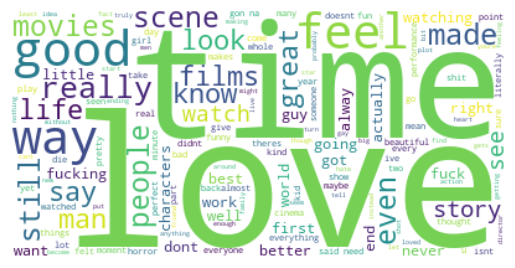

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
def generate_word_cloud():
    df = pd.read_csv("normalized_movie_reviews.csv")
    text = " ".join(str(review) for review in df.review)
    stopwords = set(STOPWORDS)
    stopwords.update(["make", "much","hes"])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
generate_word_cloud()

# NLTK Vader Sentiment Anlysis

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import csv
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text) #Uses NLTK built in analyzer
    if sentiment['compound'] >= 0.05: #If score is more than 0.05, mark as positive
        return 'Positive'
    elif sentiment['compound'] <= -0.05: #If score is less than -0.05, mark as negative
        return 'Negative'
    else:
        return 'Neutral' #Otherwise, neutral
def make_columns(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment["neg"], sentiment["neu"],sentiment["pos"],sentiment["compound"]
def nltk_sentiment_analysis():
    df = pd.read_csv("normalized_movie_reviews.csv")
    df['review'] = df['review'].apply(str)
    df['sentiment'] = df['review'].apply(analyze_sentiment) #Applies analyzer to the reviews, create new column for sentiment
    df['neg_scores'], df["neu_scores"],df["pos_scores"],df["compound_scores"]= zip(*df['review'].apply(make_columns))
    df.to_csv('nltk_analyzed_movie_reviews.csv', index=False)
nltk_sentiment_analysis()

In [4]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pandas as pd
import csv
def sklearn_sentiment_analysis():
    df = pd.read_csv("nltk_analyzed_movie_reviews.csv")
    labels = df["sentiment"].values
    vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
    #max_features=2500 uses the 2500 more frequent words to make "bag of words" feature vector
    #min_df=0.8 only uses words that occur in max 80% of reviews (we dont want words that are too common)
    #min_df=7, uses words that appear in at least 7 reviews
    
    
    processed_features = vectorizer.fit_transform(df['review'].values.astype('U')).toarray()
    #Fits our reviews data into the vector
    X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)
    #Splits data set into training, testing, and validating. I think test size is 20%, so training is 80%
    text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
    #I used the randomforestclassifier to learn
    text_classifier.fit(X_train, y_train)
    predictions = text_classifier.predict(X_test)
    #Call prediction function on the randomforestclassifier class
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test,predictions))
    print(accuracy_score(y_test, predictions))
sklearn_sentiment_analysis()

[[2125  312 1108]
 [ 106 2152  250]
 [ 363  230 5437]]
              precision    recall  f1-score   support

    Negative       0.82      0.60      0.69      3545
     Neutral       0.80      0.86      0.83      2508
    Positive       0.80      0.90      0.85      6030

    accuracy                           0.80     12083
   macro avg       0.81      0.79      0.79     12083
weighted avg       0.81      0.80      0.80     12083

0.8039394190184557


# Roberta Sentiment Analysis

In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import numpy
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def encode_text(text):
    
    encoded_text = tokenizer(str(text), return_tensors="pt", padding=True, truncation = True, max_length = 150)
    return encoded_text
df = pd.read_csv("normalized_movie_reviews.csv")
#token_val = [str(i) for i in df['review'].values]
df['encoded_text'] = df['review'].apply(encode_text)

In [14]:
print(df['encoded_text'])

0        [input_ids, attention_mask]
1        [input_ids, attention_mask]
2        [input_ids, attention_mask]
3        [input_ids, attention_mask]
4        [input_ids, attention_mask]
                    ...             
60410    [input_ids, attention_mask]
60411    [input_ids, attention_mask]
60412    [input_ids, attention_mask]
60413    [input_ids, attention_mask]
60414    [input_ids, attention_mask]
Name: encoded_text, Length: 60415, dtype: object


In [17]:

def roberta_analysis(encoded_text):
    #reshape = numpy.reshape(encoded_text, (1,696))
    try:
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
        }
        #neg_scores, neu_scores, pos_scores = scores[0], scores[1], scores[2]
        #print(scores_dict)
        return pd.DataFrame.from_dict([scores_dict])
    except RuntimeError as e:
        print("Error:", e)
        return pd.DataFrame()
    

#roberta_analysis(df['encoded_text'])
sentiment_scores_df = df['encoded_text'].apply(lambda x: roberta_analysis(x))


# Data Visualization 
### Comparing Models

In [4]:
import pandas as pd
combined_analysis = pd.read_csv('combined_analysis.csv')
combined_analysis.columns

Index(['roberta_neg', 'roberta_neu', 'roberta_pos', 'neg_scores', 'neu_scores',
       'pos_scores'],
      dtype='object')

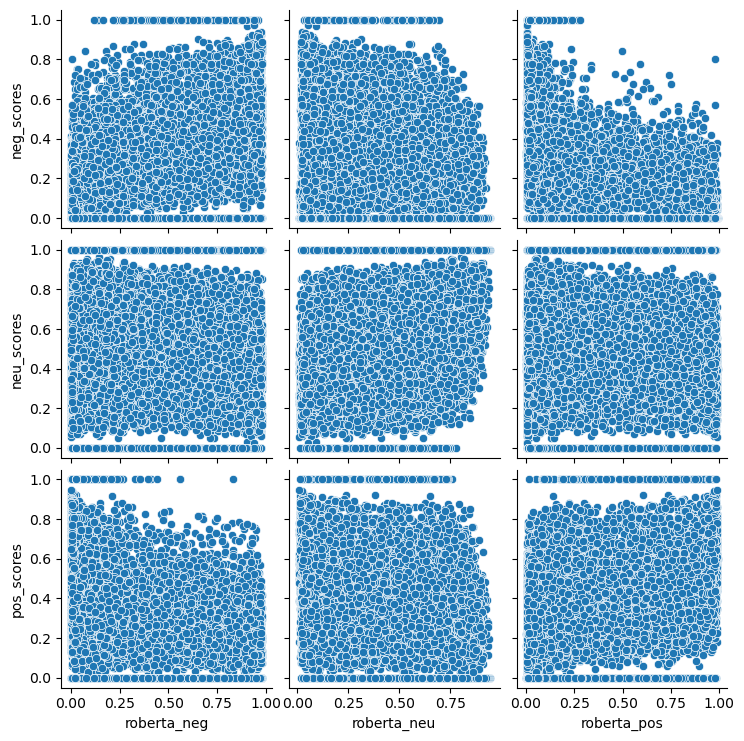

In [5]:
import seaborn as sns
sns.pairplot(data=combined_analysis, x_vars = ['roberta_neg', 'roberta_neu', 'roberta_pos'], 
             y_vars =['neg_scores', 'neu_scores', 'pos_scores'])

# Create boxplots to compare spread of data

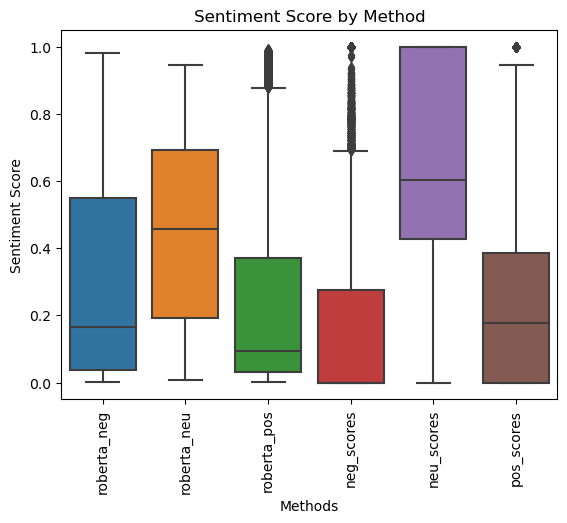

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
#create boxplots
sns.boxplot(data=combined_analysis)
#modify axis labels
plt.title("Sentiment Score by Method")
plt.ylabel("Sentiment Score")
plt.xlabel("Methods")
plt.xticks(rotation=90)
plt.show()